---
title: Blochwave Algorithm
authors: [gvarnavides]
date: 2025-01-27
---

In [98]:
import py4DSTEM
import abtem
import abtem.bloch
import ase

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors

abtem.config.set({"dask.lazy":False});

In [2]:
Si3N4_crystal = ase.Atoms(
    "Si6N8",
    scaled_positions=[
        (0.82495, 0.59387, 0.75),
        (0.23108, 0.82495, 0.25),
        (0.59387, 0.76892, 0.25),
        (0.40614, 0.23108, 0.75),
        (0.76892, 0.17505, 0.75),
        (0.17505, 0.40613, 0.25),
        
        (0.66667, 0.33334, 0.75),
        (0.33334, 0.66667, 0.25),
        (0.66986, 0.70066, 0.75),
        (0.96920, 0.66986, 0.25),
        (0.70066, 0.03081, 0.25),
        (0.29934, 0.96919, 0.75),
        (0.33015, 0.29934, 0.25),
        (0.03081, 0.33014, 0.75),
    ],
    cell=[7.6045, 7.6045, 2.9052, 90, 90, 120],
    pbc=True
)
Si3N4_orthorhombic = abtem.orthogonalize_cell(Si3N4_crystal)

In [6]:
g_max = 4
sg_max = 0.1

structure_factor = abtem.bloch.StructureFactor(
    Si3N4_orthorhombic,
    g_max=g_max,
    thermal_sigma=0.1,
    parametrization="lobato"
)

bloch_waves = abtem.bloch.BlochWaves(
    structure_factor=structure_factor,
    energy=300e3,
    sg_max=sg_max,
)

In [7]:
cell_thickness = Si3N4_orthorhombic.cell[2,2]
cell_thicknesses = np.arange(cell_thickness,cell_thickness*5,cell_thickness)

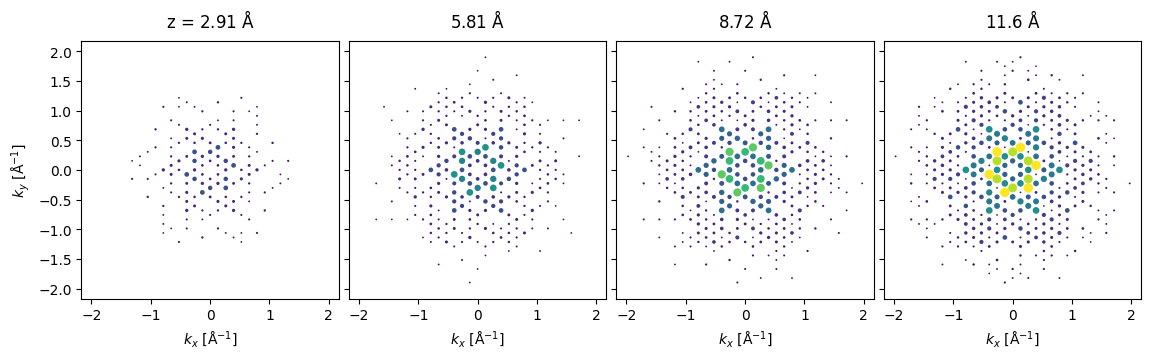

In [8]:
bloch_waves.calculate_diffraction_patterns(
    cell_thicknesses,
    lazy=False,
).block_direct(
).show(
    scale=0.08,
    power=0.5,
    explode=True,
    annotations=False,
    common_color_scale=True,
    figsize=(12,4)
);

## Precession Electron Diffraction

In [9]:
from scipy.spatial.transform import Rotation

x_angles = np.linspace(0,120e-3,4)
y_angles = np.linspace(120e-3,0,4)
xy_angles = np.dstack(np.meshgrid(x_angles,y_angles,indexing='ij')).reshape((-1,2))

orientation_matrices = Rotation.from_euler('xy',xy_angles).as_matrix()

bloch_matrices = [
    abtem.bloch.BlochWaves(
        structure_factor=structure_factor,
        energy=300e3,
        sg_max=sg_max,
        orientation_matrix=orientation,
    ) for orientation in orientation_matrices
]

dps = [
    bloch.calculate_diffraction_patterns(
        thicknesses=np.array([cell_thickness*5]),
        lazy=False,
    ).block_direct(
    ) for bloch in bloch_matrices
]


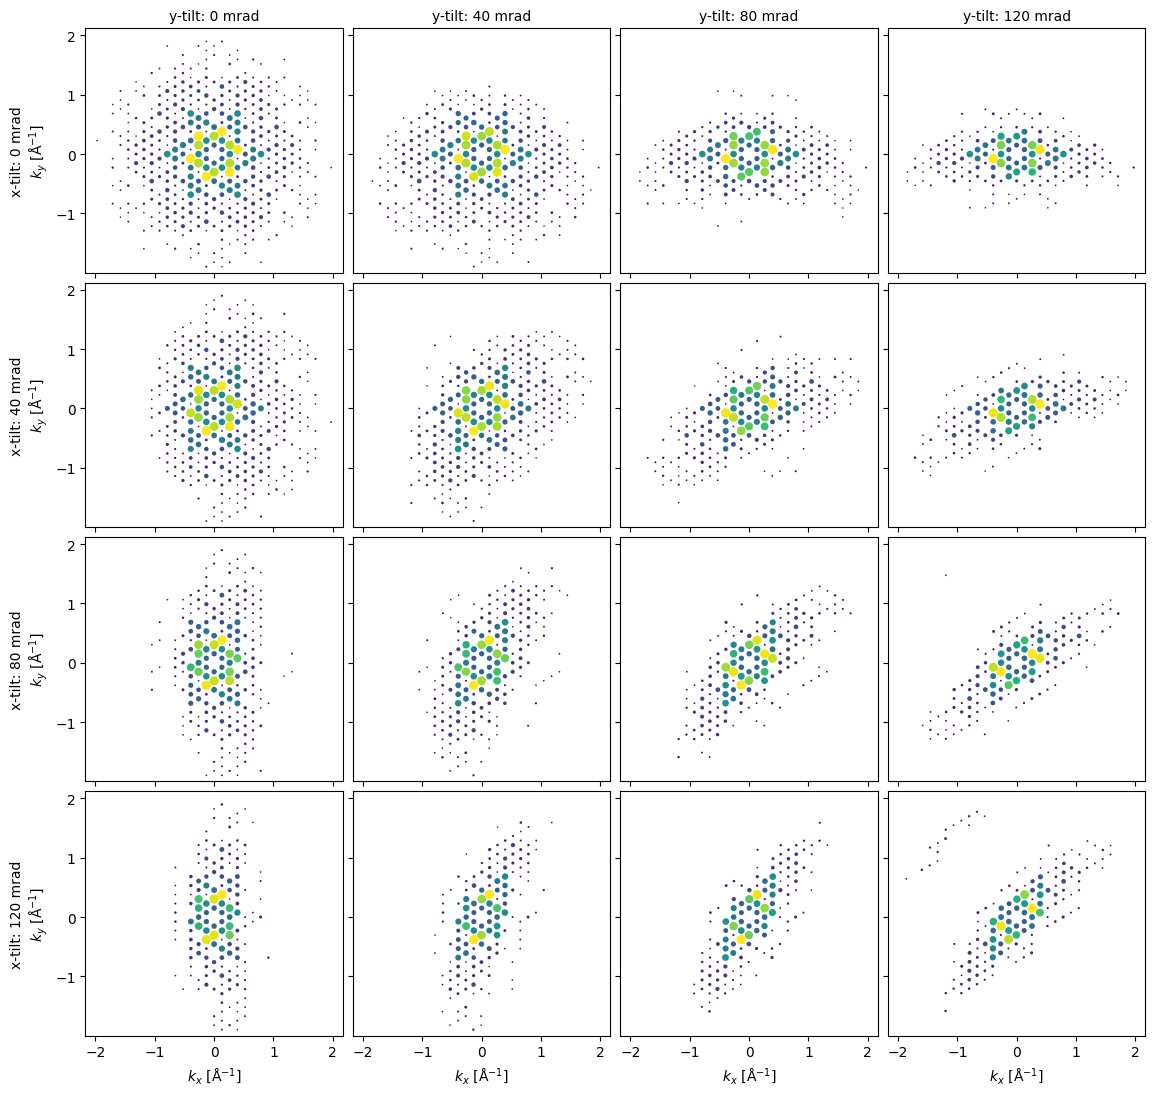

In [107]:
fig = plt.figure(figsize=(12,12))
axes = abtem.visualize.axes_grid.AxesGrid(
    fig=fig,
    ncols=4,
    nrows=4,
)._axes

y_indices = np.tile(np.arange(4),4)
x_indices = np.repeat(np.arange(4),4)

for ax, dp, x_ind, y_ind in zip(axes.ravel(),dps,x_indices, y_indices):
    dp.show(
        scale=0.08,
        power=0.5,
        annotations=False,
        ax=ax
    )
    if x_ind == 0:
        label = ax.get_ylabel()
        ax.set_ylabel(f"x-tilt: {x_angles[3-y_ind]*1e3:.0f} mrad\n"+label)
    if y_ind == 3:
        ax.set_title(f"y-tilt: {y_angles[3-x_ind]*1e3:.0f} mrad",fontsize=10)

## Blochwaves with py4DSTEM

In [109]:
Si3N4_py4d = py4DSTEM.process.diffraction.Crystal(
    positions=Si3N4_orthorhombic.get_scaled_positions(),
    numbers=Si3N4_orthorhombic.numbers,
    cell=Si3N4_orthorhombic.cell.array,
)

# Si3N4_py4d.calculate_structure_factors(
#     k_max=g_max,
#     tol_structure_factor=-1,
# )

Si3N4_py4d.calculate_dynamical_structure_factors(
    300e3,
    "Lobato",
    k_max=g_max,
    thermal_sigma=0.1,
    # tol_structure_factor=-1,
)

In [110]:
ZA = np.array([0,0,1])

beams = Si3N4_py4d.generate_diffraction_pattern(
    zone_axis_lattice=ZA,
    sigma_excitation_error=sg_max,
)

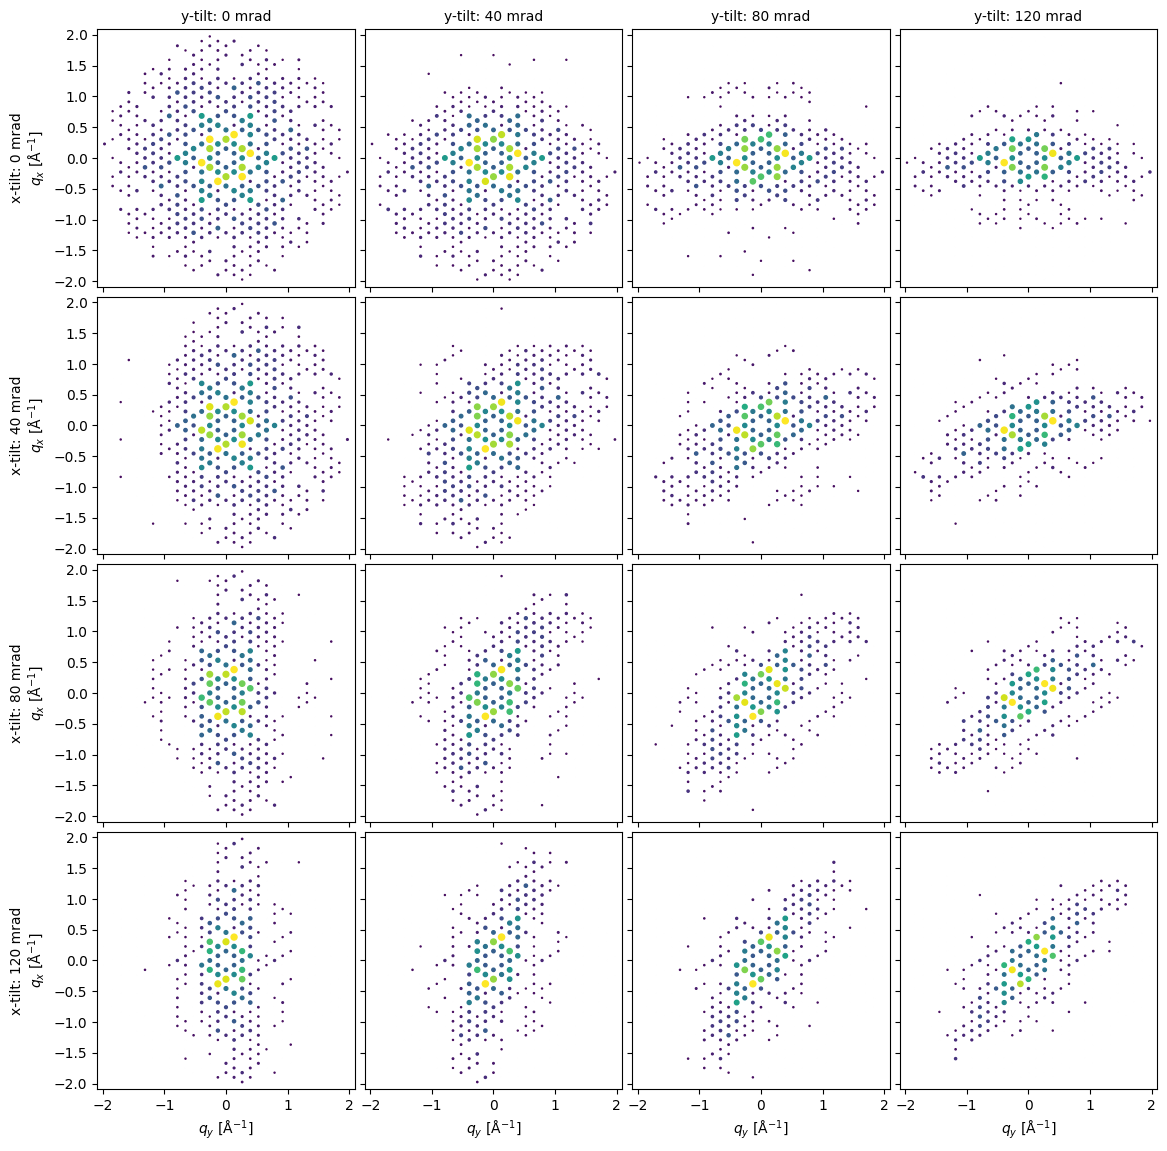

In [136]:
rotated_ZAs = Rotation.from_matrix(orientation_matrices).apply(ZA)

fig = plt.figure(figsize=(12,12))
axes = abtem.visualize.axes_grid.AxesGrid(
    fig=fig,
    ncols=4,
    nrows=4,
)._axes

for za, ax, x_ind, y_ind in zip(rotated_ZAs,axes.ravel(),x_indices, y_indices):
    dynamical_beams = Si3N4_py4d.generate_dynamical_diffraction_pattern(
        beams=beams,
        thickness=cell_thickness*5,
        zone_axis_cartesian=za,
    )
    
    # block direct beam
    direct_index = np.where(
        (dynamical_beams['h'] == 0) & 
        (dynamical_beams['k'] == 0) & 
        (dynamical_beams['l'] == 0)
    )[0][0]
    
    clipped_intensity = dynamical_beams['intensity'].copy()
    clipped_intensity[direct_index] = 0.0

    # clip low intensities
    clipped_intensity[clipped_intensity<1e-6] = 0.0
    dynamical_beams.data['intensity'] = clipped_intensity
    
    py4DSTEM.process.diffraction.plot_diffraction_pattern(
        dynamical_beams,
        add_labels=False,
        power_markers=0.5,
        input_fig_handle=(fig,(ax,))
    )
    ax.xaxis.tick_bottom()
    ax.invert_yaxis()

    # transpose x and y to match abtem
    col = ax.collections[0]
    col.set_offsets(np.flip(col.get_offsets(),axis=1))

    # set colors 
    norm = matplotlib.colors.Normalize()
    colors = cm.viridis(norm(clipped_intensity**0.5))
    col.set_color(colors)
    
    if x_ind == 0:
        label = ax.get_ylabel()
        ax.set_ylabel(f"x-tilt: {x_angles[3-y_ind]*1e3:.0f} mrad\n"+label)
    if y_ind == 3:
        ax.set_title(f"y-tilt: {y_angles[3-x_ind]*1e3:.0f} mrad",fontsize=10)

## CBED Patterns

In [138]:
cbed = Si3N4_py4d.generate_CBED(
    beams=beams,
    thickness=cell_thickness*5,
    alpha_mrad=1,
    pixel_size_inv_A=0.01,
    zone_axis_lattice=ZA,
)

100%|███████████████████████████████████████████████████████████████| 69/69 [00:22<00:00,  3.06it/s]


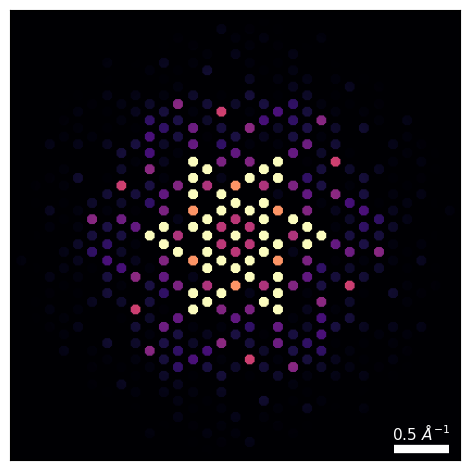

In [139]:
fig,ax = plt.subplots()

py4DSTEM.show(
    cbed.T,
    cmap='magma',
    ticks=False,
    figax=(fig,ax),
    vmin=0.015,
    vmax=0.985,
    scalebar=True,
    pixelsize=0.01,
    pixelunits=r"$\AA^{-1}$"
)

# ax.invert_yaxis()
fig.tight_layout()